In [1]:
%matplotlib inline
from preamble import *

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import plotting as pl

### Read in the data

In [2]:
data = pd.read_csv('data/higgs_data.csv')

higgs_85 = pd.read_csv('data/higgs_higgs_85.csv')
higgs_90 = pd.read_csv('data/higgs_higgs_90.csv')
higgs_95 = pd.read_csv('data/higgs_higgs_95.csv')
eeqq = pd.read_csv('data/higgs_eeqq.csv')
qq = pd.read_csv('data/higgs_qq.csv')
wen = pd.read_csv('data/higgs_wen.csv')
ww = pd.read_csv('data/higgs_ww.csv')
zee = pd.read_csv('data/higgs_zee.csv')
zz = pd.read_csv('data/higgs_zz.csv')


framesMC_NoHiggs = [qq, ww, zz, zee, wen, eeqq]
framesMC_NoHiggsNames = ['qq', 'ww', 'zz', 'zee', 'wen', 'eeqq']

framesMC_HiggsModels = [higgs_85, higgs_90, higgs_95]
framesMC_HiggsModelsNames = ['higgs_85', 'higgs_90', 'higgs_95']

<img src="samples_full.png"> 

### Introduce weights in order to rescale all the MC samples to the same luminosity

per definition the weight of each measured event (data) is $1$. Thus, we want to rescale the MC to the same ntegrated Luminosity of the data taking which is $L = 176.773 \ \mathrm{pb}^{-1}$

The weight for each MC sample is:
$$ 
        \mathrm{weight}_\mathrm{MC} = L \cdot  \frac{\sigma_\mathrm{MC} }{N_\mathrm{MC}}
$$

In [3]:
crossSectionsMC_noHiggs = [102., 16.5, 0.975, 3.35, 2.9, 15600.]
NumberMC_noHiggs = [200000., 294500., 196000., 29500., 81786., 5940000.]

crossSectionsMC_HiggsModels = [0.094, 0.0667, 0.0333]
NumberMC_HiggsModels = [3972., 3973., 3971.]


Lum = 176.773


weightsMC_noHiggs     = Lum*np.array(crossSectionsMC_noHiggs) / np.array(NumberMC_noHiggs) 
weightsMC_HiggsModels = Lum*np.array(crossSectionsMC_HiggsModels) / np.array(NumberMC_HiggsModels) 


#add column 'weight' to data frame of all bkg MC
for i, frame in enumerate(framesMC_NoHiggs):
    frame["weight"] = weightsMC_noHiggs[i]
    frame["class"] = 0

#add column 'weight' to data frame of all bkg+sig MC
for i, frame in enumerate(framesMC_HiggsModels):
    frame["weight"] = weightsMC_HiggsModels[i]
    frame["class"] = 1
    
#add column 'weight'=1 to data 
data["weight"] = 1



In [4]:
df_MC_noHiggs = pd.concat(framesMC_NoHiggs)
df_MC_mH85 = framesMC_HiggsModels[0]
df_mH85 = pd.concat([df_MC_noHiggs,framesMC_HiggsModels[0]])

## Perform selection cut analysis

In [5]:
len(df_mH85['weight'])

76919

In [6]:
def PickDiscVar_mH85 (df) :
    discriminating_vars = ['btag1','btag2','ucsdbt0','acthm','mvissc','mmis']+['class','weight']
    discriminating_vars = ['ucsdbt0','acthm','mvissc','mmis','xmj1','acop']+['class','weight']
    discriminating_vars = [u'btag1', u'btag2',
       u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis', u'fth1',
       u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
       u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2',
       u'pho_num', u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene',
       u'ele_the', u'ele_phi', u'muon_num', u'muon_ene', u'muon_the',
       u'muon_phi']+['class','weight']
    return df[discriminating_vars]

In [7]:
df_MVA_mH85 = PickDiscVar_mH85(df=df_mH85)

In [8]:
df_MVA_mH85.columns

Index([u'btag1', u'btag2', u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis',
       u'fth1', u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
       u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2',
       u'pho_num', u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene',
       u'ele_the', u'ele_phi', u'muon_num', u'muon_ene', u'muon_the',
       u'muon_phi', u'class', u'weight'],
      dtype='object')

In [9]:
# extract target values
target = df_MVA_mH85['class']
del df_MVA_mH85['class']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_MVA_mH85, target, 
                                                    stratify=target, 
                                                    random_state=42,
                                                   train_size=0.65)
X_train_w = X_train['weight']
X_test_w = X_test['weight']


print('No of train events', len(y_train))
print('No of signal events',np.count_nonzero(y_train))

print('fraction of bkg in training set',1 - 1.*np.count_nonzero(y_train) / len(y_train))

print('-----------------------------')
print('same for test set')
print(len(y_test))
print(np.count_nonzero(y_test))
print(1 - 1.*np.count_nonzero(y_test) / len(y_test))


del X_train['weight']
del X_test['weight']


('No of train events', 49997)
('No of signal events', 2179)
('fraction of bkg in training set', 0.9564173850431026)
-----------------------------
same for test set
26922
1174
0.956392541416


In [11]:
from sklearn.svm import SVC

In [39]:
# Compute the minimum value per feature on the training set
min_on_training = X_train.min(axis=0)
# Compute the range of each feature (max - min) on the training set
range_on_training = (X_train - min_on_training).max(axis=0)

print np.array(min_on_training)
print np.array(range_on_training)

# subtract the min, divide by range
# afterwards min=0 and max=1 for each feature
X_train_scaled = (X_train - min_on_training) / range_on_training
print("Minimum for each feature\n{}".format(X_train_scaled.min(axis=0)))
print("Maximum for each feature\n {}".format(X_train_scaled.max(axis=0)))

[  0.      0.      0.     40.469  50.749  46.922  91.013   0.137  50.      0.
   0.002   0.003   0.041  28.927   0.246   0.      2.04    8.356   0.016
   0.      2.004   0.     -1.      0.      0.      0.     -1.      0.      0.
   0.     -1.      0.      0.   ]
[  1.      1.     16.493  97.858  47.048  50.98    0.698   2.953  79.988
   0.96    0.998   3.138   0.839  66.076   2.65    6.283  67.932  60.739
   3.119   6.283  54.567   6.     62.469   2.953   6.284   4.     67.375
   2.888   6.283   3.     70.25    2.749   6.283]
Minimum for each feature
btag1       0.0
btag2       0.0
ucsdbt0     0.0
mvis        0.0
mvissc      0.0
fmvis       0.0
fmmis       0.0
fth1        0.0
mmis        0.0
acthm       0.0
maxcthj     0.0
acop        0.0
maxxov      0.0
enj1        0.0
thj1        0.0
phj1        0.0
xmj1        0.0
enj2        0.0
thj2        0.0
phj2        0.0
xmj2        0.0
pho_num     0.0
pho_ene     0.0
pho_the     0.0
pho_phi     0.0
ele_num     0.0
ele_ene     0.0
ele_the    

In [13]:
# use THE SAME transformation on the test set,
# using min and range of the training set. See Chapter 3 (unsupervised learning) for details.
X_test_scaled = (X_test - min_on_training) / range_on_training

In [19]:
#svc = SVC(class_weight= {0:.1, 1:.9})
svc = SVC(class_weight='balanced')
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
        svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.825
Accuracy on test set: 0.824


In [20]:
"""svc = SVC(class_weight= {0:.1, 1:.9})
svc.fit(X_train,y_train,sample_weight=X_train_w)"""

'svc = SVC(class_weight= {0:.1, 1:.9})\nsvc.fit(X_train,y_train,sample_weight=X_train_w)'

In [13]:
print("Training set score: {:.3f}".format(svc.score(X_train, y_train,sample_weight=X_train_w)))
print("Test set score: {:.3f}".format(svc.score(X_test, y_test,sample_weight=X_test_w)))

Training set score: 0.979
Test set score: 0.979


In [37]:
import cPickle
# save the classifier
with open('SVM_PreProcessed_balanced.pkl', 'wb') as fid:
    cPickle.dump(svc, fid)    


In [22]:
from sklearn.metrics import confusion_matrix
import itertools
y_pred = svc.predict(X_test_scaled)



26922
26922
5535
1174
[[21200  4548]
 [  187   987]]
26922
[[ 0.823  0.177]
 [ 0.159  0.841]]


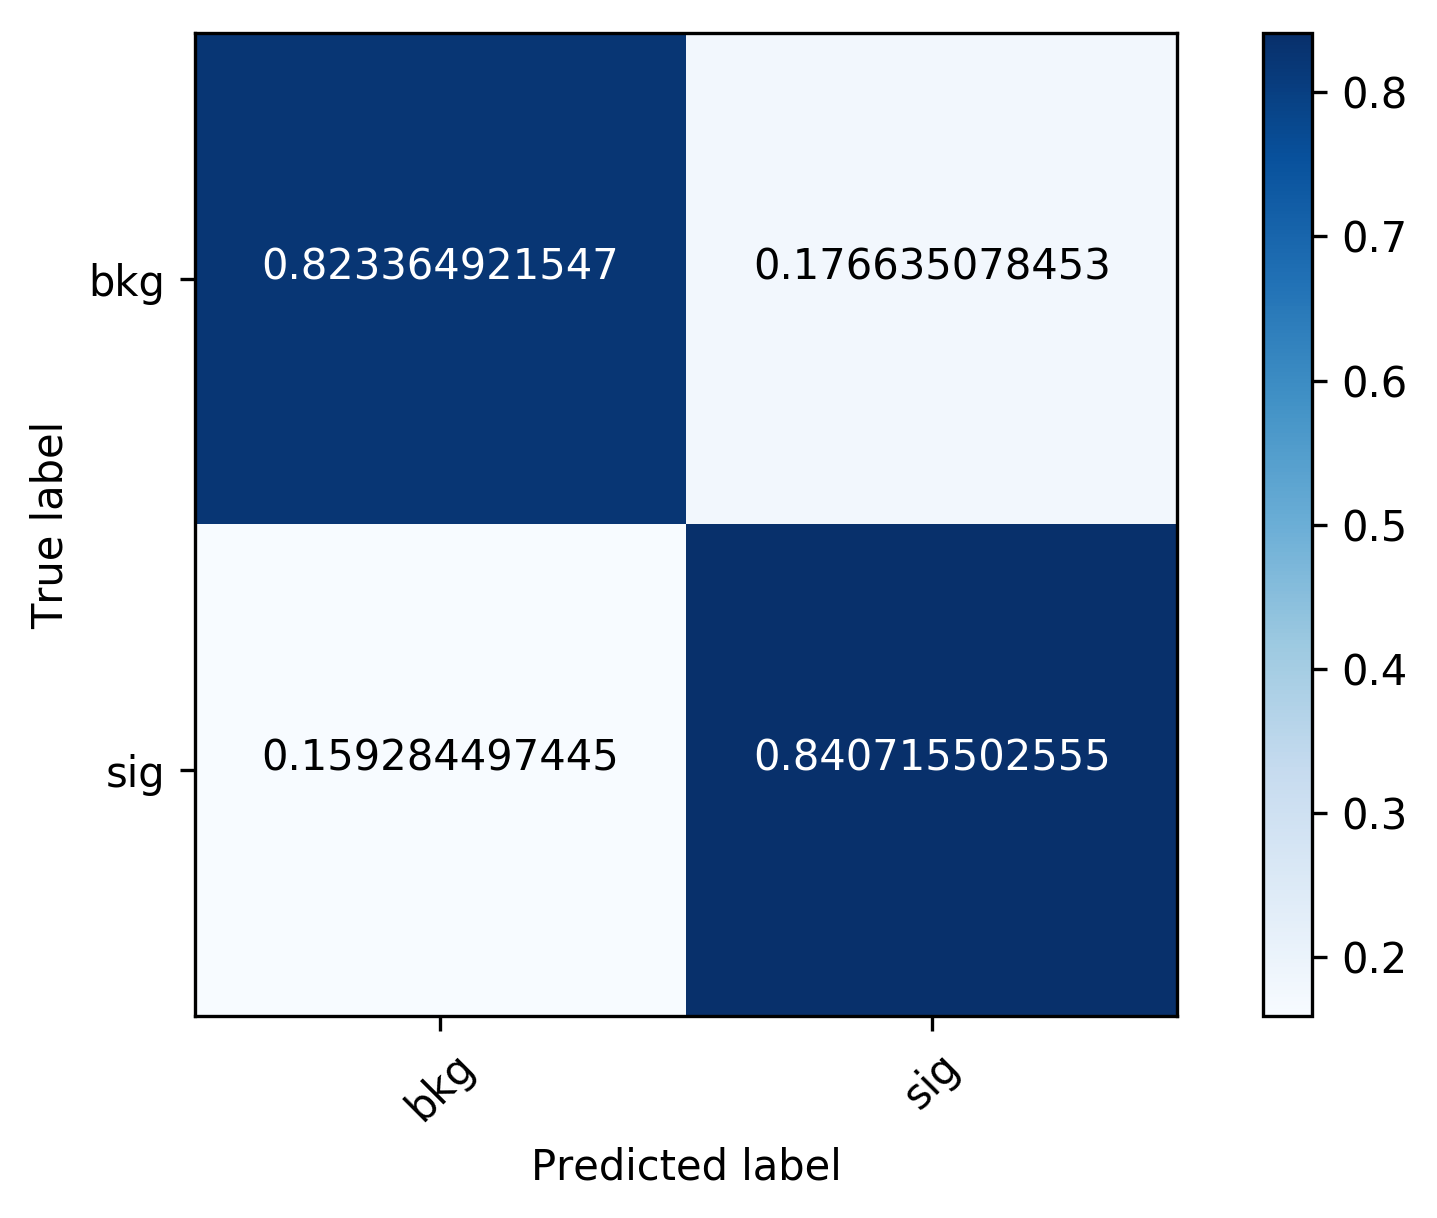

In [29]:
print(len(y_pred))
print len(y_test)

print(np.count_nonzero(y_pred))
print(np.count_nonzero(y_test))
cm = confusion_matrix(y_pred,y_test)#,labels=["bkg","sig"])
cm = cm.T
print cm
print sum(sum(cm))
cmap = plt.cm.Blues
# normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print cm

plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
tick_marks = np.arange(2)
classes = ['bkg','sig']
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)



thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

In [30]:
a  = X_train.min(axis=0)
print type(np.array(a))

<type 'numpy.ndarray'>


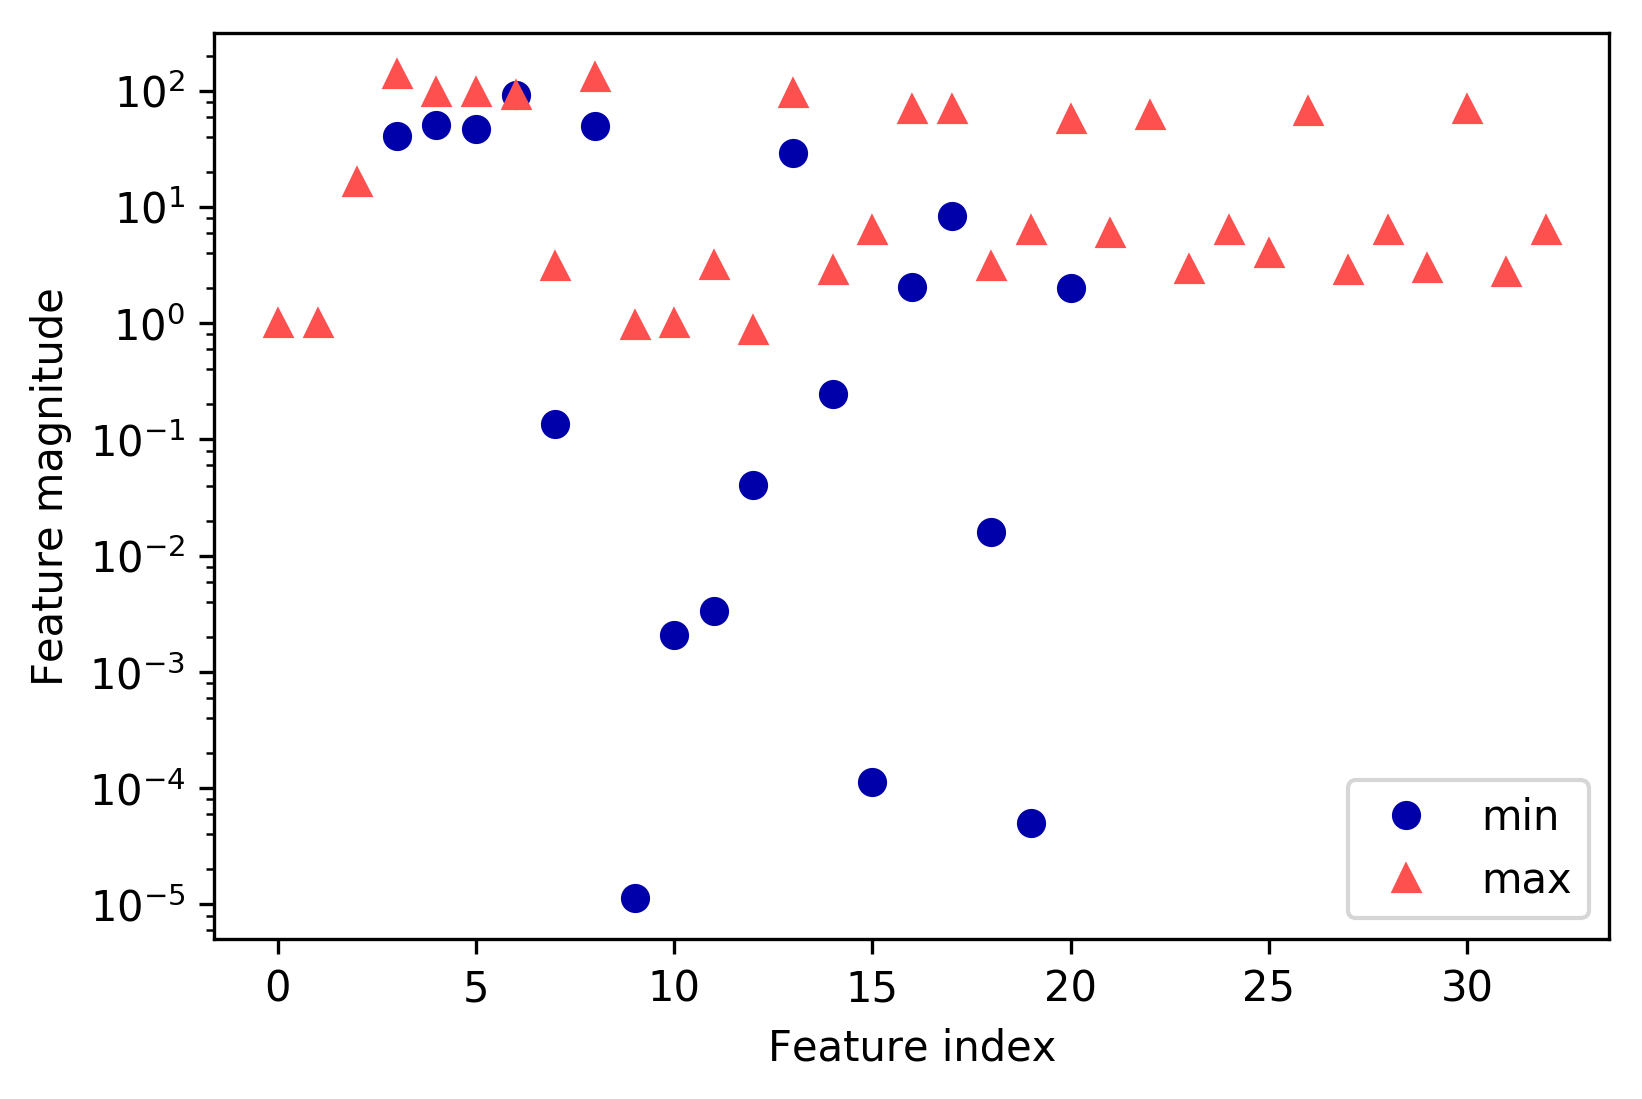

In [25]:
plt.plot(np.array(X_train.min(axis=0)), 'o', label="min")
plt.plot(np.array(X_train.max(axis=0)), '^', label="max")
plt.legend(loc=4)
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")
plt.yscale("log")
plt.show()

In [31]:
X_train_df = X_train_scaled.copy()
X_train_df['class'] = y_train

X_test_df = X_test_scaled.copy()
X_test_df['class'] = y_test

In [33]:
X_train_bkg = X_train_df[X_train_df['class']==0]
X_train_sig = X_train_df[X_train_df['class']==1]
del X_train_bkg['class']
del X_train_sig['class']

X_test_bkg = X_test_df[X_test_df['class']==0]
X_test_sig = X_test_df[X_test_df['class']==1]
del X_test_bkg['class']
del X_test_sig['class']

a_bkg = svc.decision_function(X_train_bkg)
a_sig = svc.decision_function(X_train_sig)

b_bkg = svc.decision_function(X_test_bkg)
b_sig = svc.decision_function(X_test_sig)

print len(a_bkg)
binning = np.linspace(min(b_bkg),max(a_sig),30)


47818


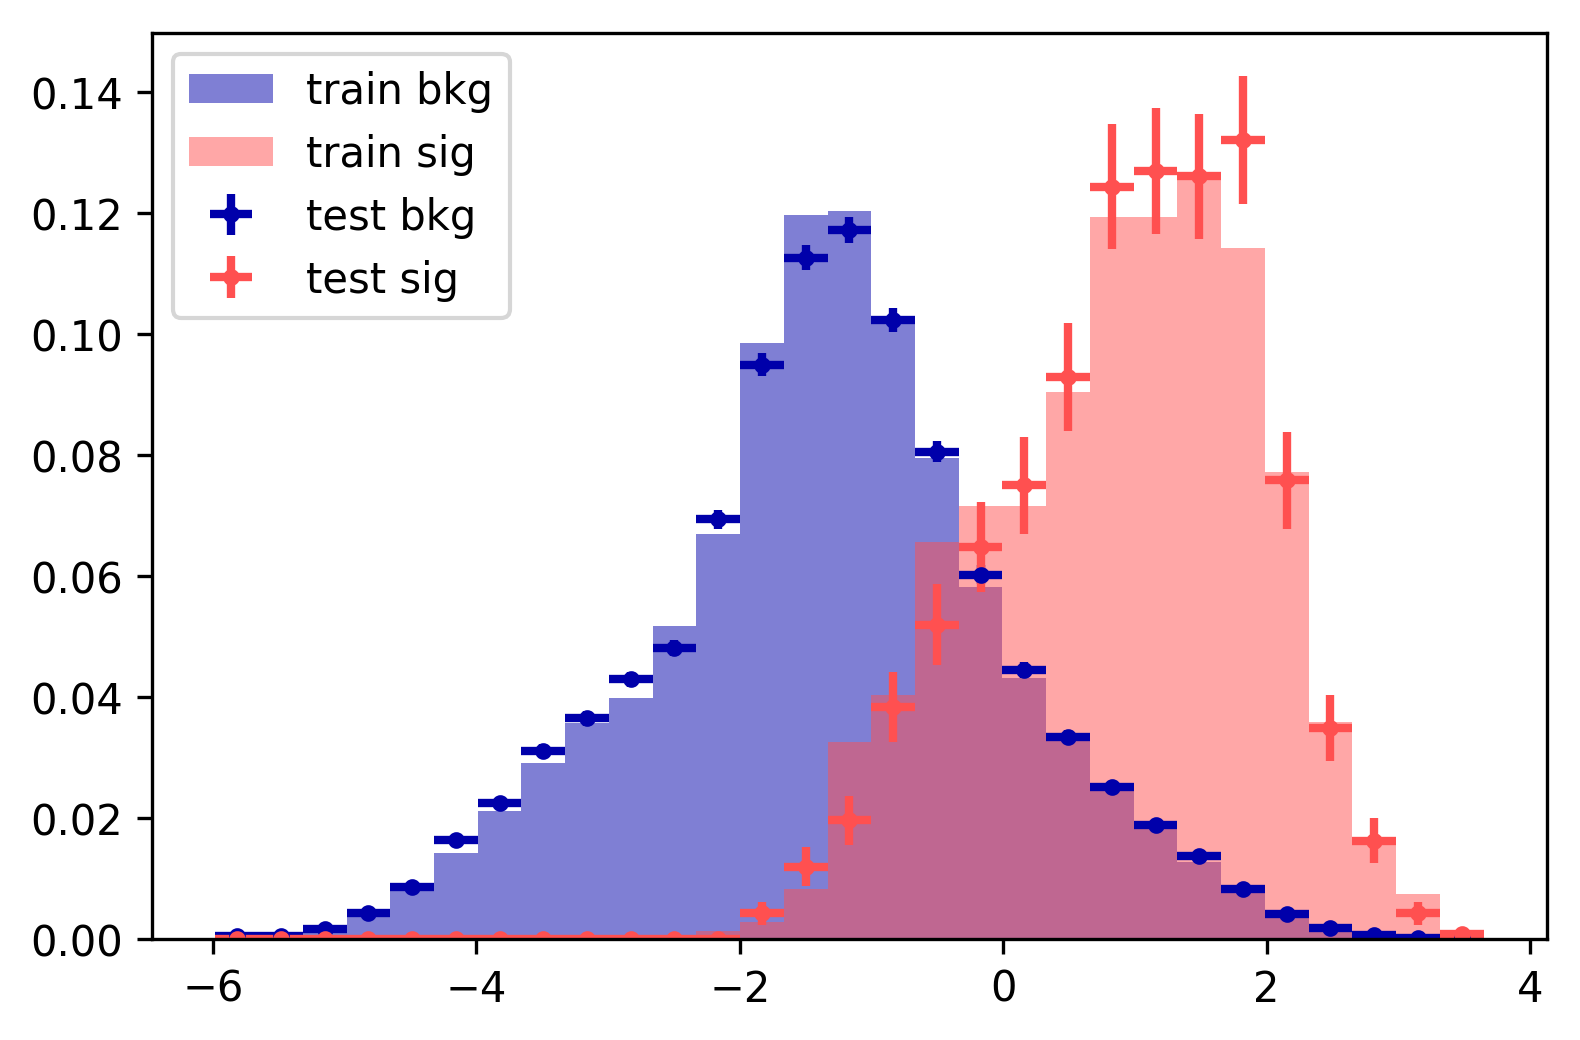

In [34]:
n = True
binw = binning[1] - binning[0]

N_a_bkg = np.histogram(a_bkg,bins=binning)[0]
norm_a_bkg = 1.*len(a_bkg)
N_a_sig = np.histogram(a_sig,bins=binning)[0]
norm_a_sig = 1.*len(a_sig)

#plt.hist(a_bkg,bins=binning,label='train bkg',alpha=0.5)
#plt.hist(a_sig,bins=binning,label='train sig',alpha=0.5)

plt.bar(left=binning[:-1],height=N_a_bkg/norm_a_bkg,width=binw,label='train bkg',alpha=0.5)
plt.bar(left=binning[:-1],height=N_a_sig/norm_a_sig,width=binw,label='train sig',alpha=0.5)



N_bkg = np.histogram(b_bkg,bins=binning)[0]
norm_bkg = 1.*len(b_bkg)

N_sig = np.histogram(b_sig,bins=binning)[0]
norm_sig = 1.*len(b_sig)

#print(sum(N_sig/norm_sig))

plt.errorbar(binning[:-1],N_bkg/norm_bkg,xerr=binw/2.,label='test bkg',
            yerr=np.sqrt(N_bkg)/norm_bkg,fmt='.')
plt.errorbar(binning[:-1],N_sig/norm_sig,xerr=binw/2.,label='test sig',
            yerr=np.sqrt(N_sig)/norm_sig,fmt='.')
            

plt.legend()
plt.show()

In [35]:
print N_sig
print N_bkg
print np.sqrt(N_bkg)

sum_sig_cuts = []
sum_bkg_cuts = []

count = 0
for s in N_sig :
    count += s
    sum_sig_cuts.append(count)

count = 0
for s in N_bkg :
    count += s
    sum_bkg_cuts.append(count)

    
print sum_sig_cuts
print sum_bkg_cuts


print np.sqrt(-2*(N_sig+N_bkg)*np.log(1+N_sig/N_bkg) + 2*N_sig)

[  0   0   0   0   0   0   0   0   0   0   0   0   5  14  23  45  61  76
  88 109 146 149 148 155  89  41  19   5   1]
[  10   11   43  112  221  422  577  800  938 1104 1237 1785 2444 2899 3016
 2634 2073 1550 1146  858  646  485  353  211  104   46   16    5    2]
[  3.162   3.317   6.557  10.583  14.866  20.543  24.021  28.284  30.627
  33.226  35.171  42.249  49.437  53.842  54.918  51.323  45.53   39.37
  33.853  29.292  25.417  22.023  18.788  14.526  10.198   6.782   4.
   2.236   1.414]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 19, 42, 87, 148, 224, 312, 421, 567, 716, 864, 1019, 1108, 1149, 1168, 1173, 1174]
[10, 21, 64, 176, 397, 819, 1396, 2196, 3134, 4238, 5475, 7260, 9704, 12603, 15619, 18253, 20326, 21876, 23022, 23880, 24526, 25011, 25364, 25575, 25679, 25725, 25741, 25746, 25748]
[  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      3.162   5.292   6.782   9.487  11.045  12.329  13.266
  14.765  17.088  17.263  17.205  17.607  13

/home/janik/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in sqrt


1.82037298463


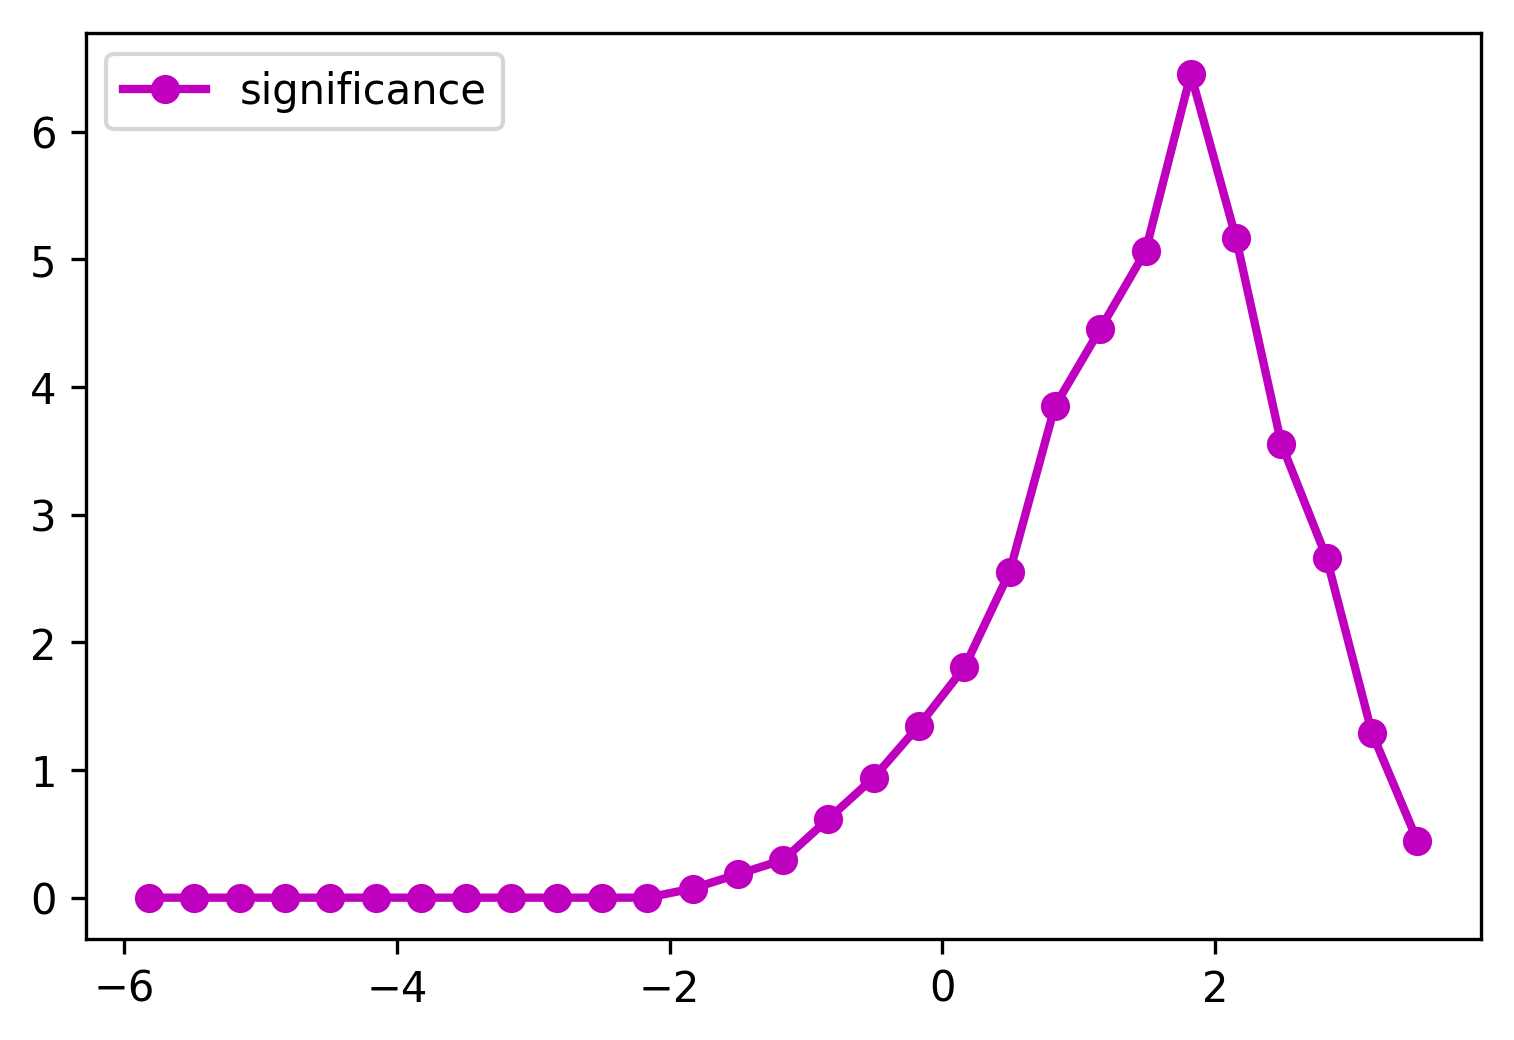

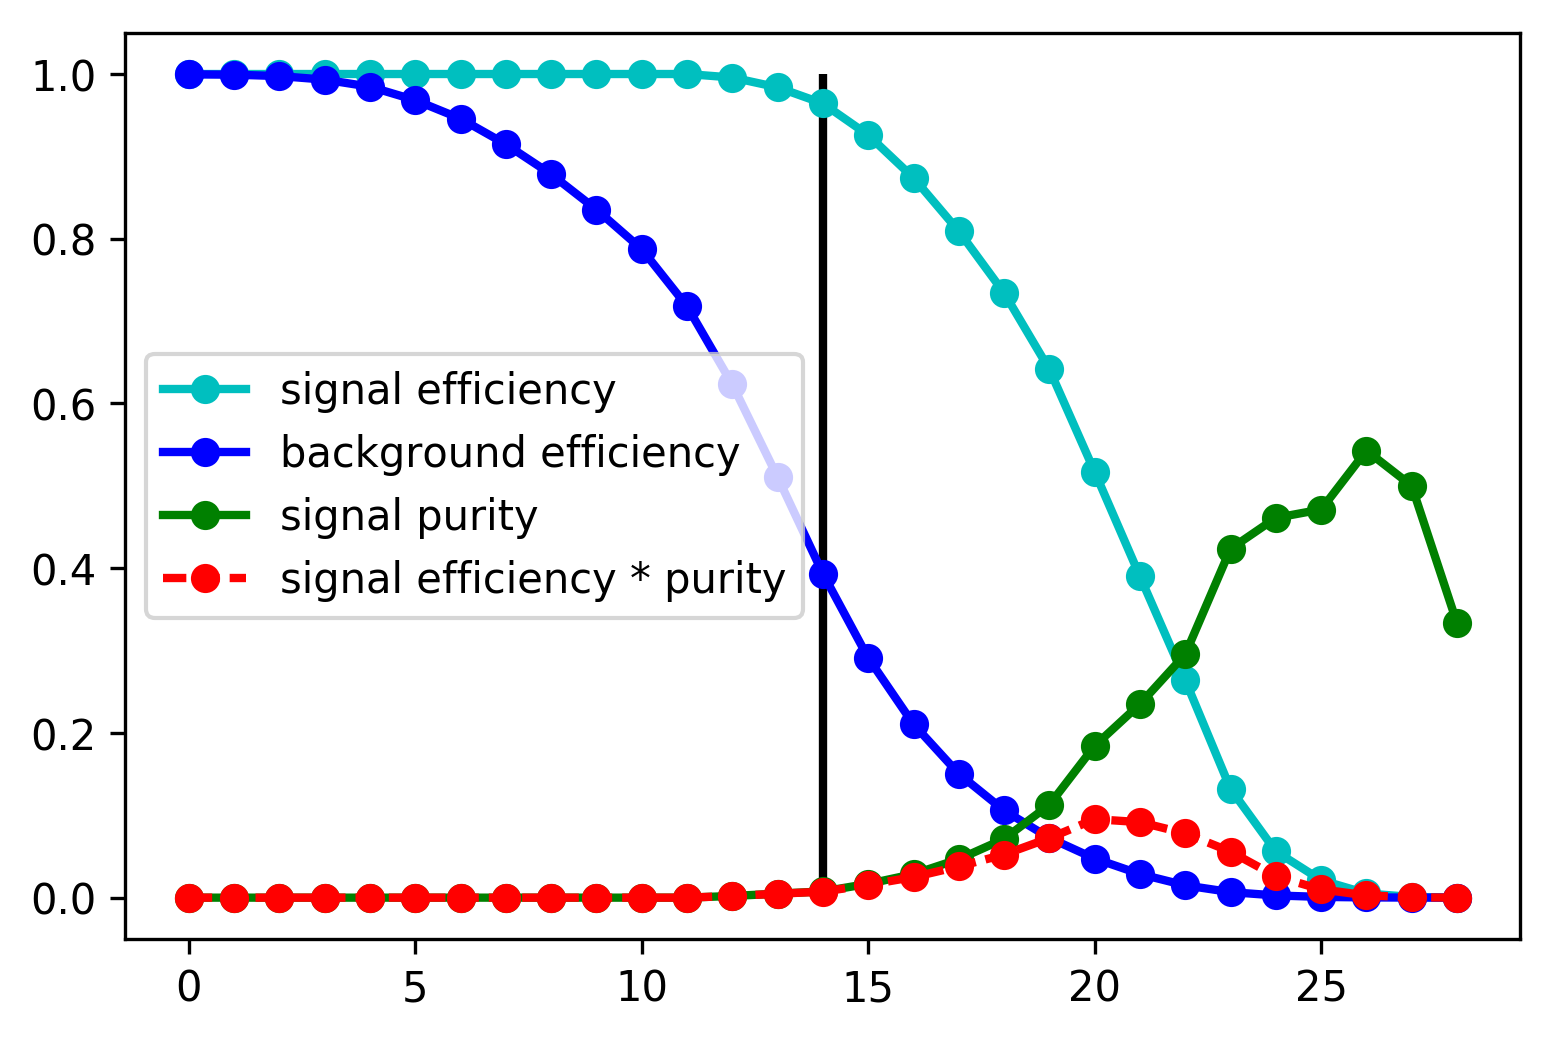

In [36]:
plt.plot(binning[:-1],1.*N_sig/(np.sqrt(N_sig + N_bkg + N_bkg)),'mo-',label='significance')
print binning[:-1][np.argmax(1.*N_sig/(np.sqrt(N_sig + N_bkg + N_bkg)))]
#plt.plot(np.sqrt(-2*(N_sig+N_bkg)*np.log(1+N_sig/N_bkg) + 2*N_sig),'ro--', label='lr significance')
#plt.hlines(3.,0,30)
#plt.vlines(14,0,7)
plt.legend()
plt.show()

plt.vlines(14,0,1)
plt.plot(1.-(np.array(sum_sig_cuts))/norm_sig,'co-',label='signal efficiency')
plt.plot(1.-(np.array(sum_bkg_cuts))/norm_bkg,'bo-',label='background efficiency')
plt.plot(1.*N_sig / (N_sig+N_bkg),'go-',label='signal purity')
plt.plot((1.*N_sig / (N_sig+N_bkg))*(1.-(np.array(sum_sig_cuts))/norm_sig),'ro--',label='signal efficiency * purity')
plt.legend()
plt.show()

# Gradient Boosted Decision Trees Attempt

In [15]:
grbcl = GradientBoostingClassifier(max_depth=3,random_state=0)
grbcl.fit(X_train,y_train,sample_weight=X_train_w)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)

In [16]:
print("Training set score: {:.3f}".format(grbcl.score(X_train, y_train)))
print("Test set score: {:.3f}".format(grbcl.score(X_test, y_test)))

Training set score: 0.952
Test set score: 0.949


In [17]:
df_MVA_mH85.columns

Index([u'btag1', u'btag2', u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis',
       u'fth1', u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'ghmass',
       u'enj1', u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2',
       u'pho_num', u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene',
       u'ele_the', u'ele_phi', u'muon_num', u'muon_ene', u'muon_the',
       u'muon_phi', u'weight'],
      dtype='object')

In [18]:
grbcl.feature_importances_

array([ 0.091,  0.12 ,  0.102,  0.065,  0.071,  0.038,  0.021,  0.005,
        0.045,  0.017,  0.013,  0.077,  0.088,  0.109,  0.007,  0.006,
        0.003,  0.047,  0.011,  0.015,  0.007,  0.015,  0.   ,  0.   ,
        0.012,  0.003,  0.002,  0.005,  0.004,  0.003,  0.   ,  0.   ,
        0.   ,  0.   ])

26922
26922


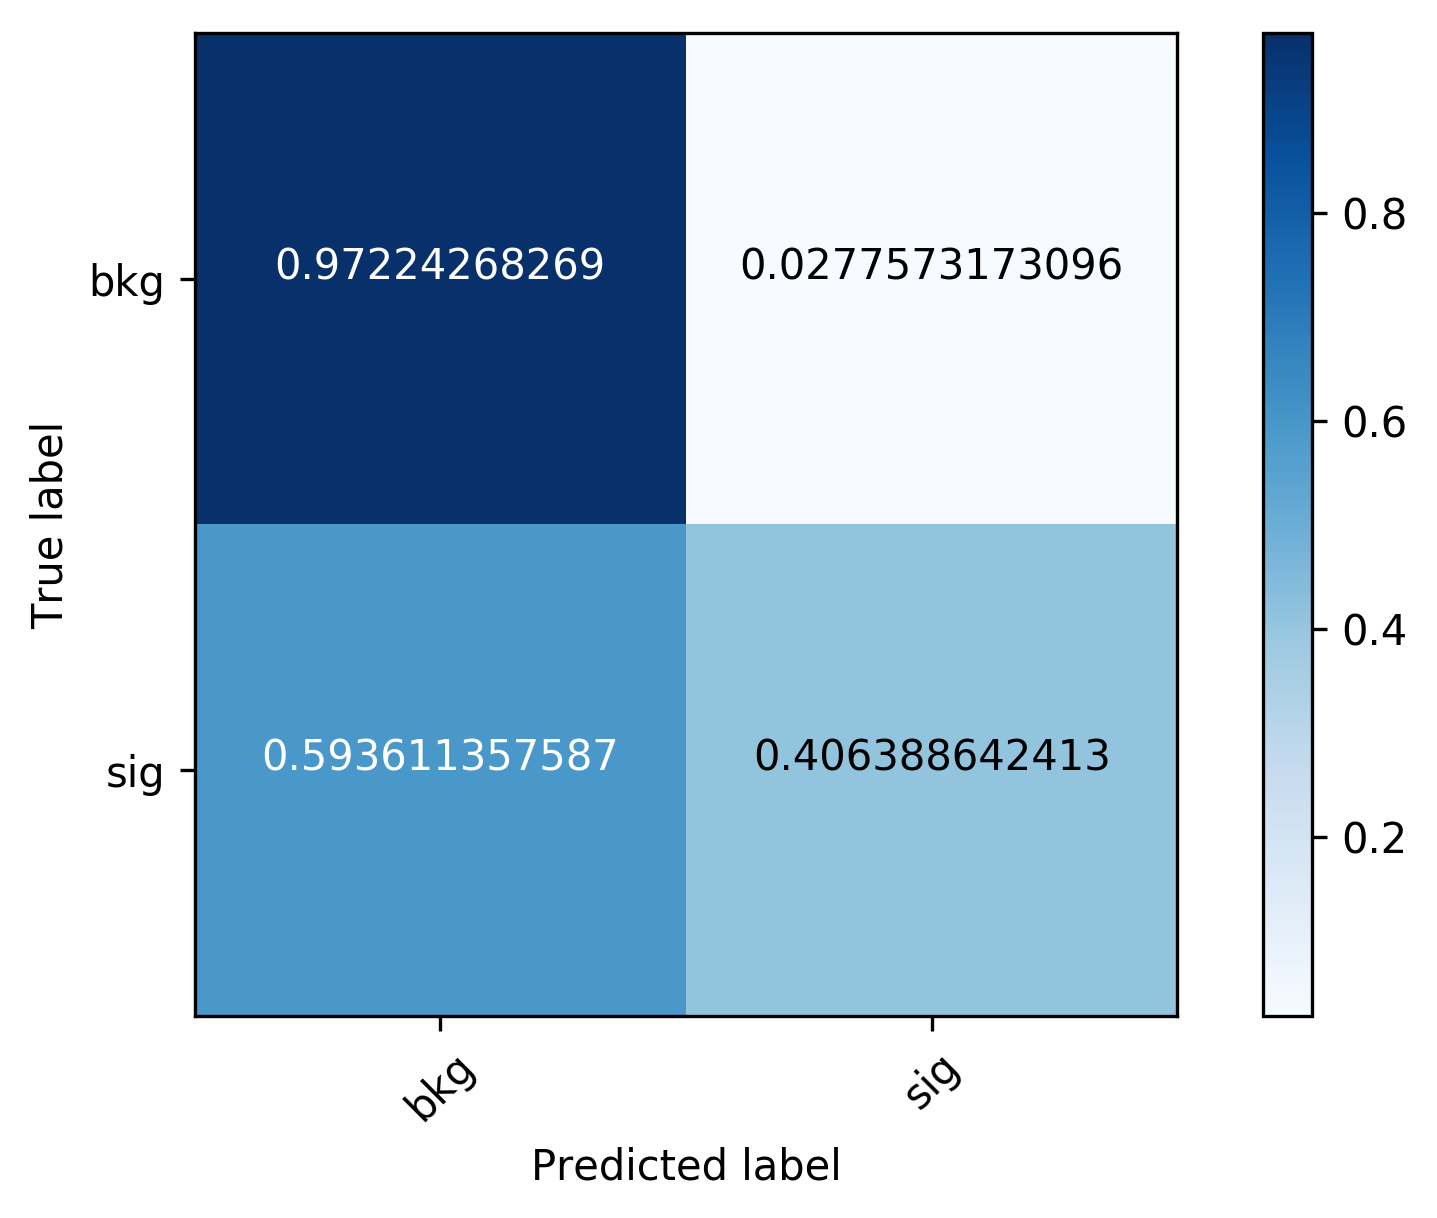

In [33]:
from sklearn.metrics import confusion_matrix
import itertools
y_pred = grbcl.predict(X_test)

print(len(y_pred))
print len(y_test)

cm = confusion_matrix(y_pred,y_test)#,labels=["bkg","sig"])

cmap = plt.cm.Blues
# normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
tick_marks = np.arange(2)
classes = ['bkg','sig']
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)



thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

In [29]:
print np.count_nonzero(y_test)
print np.count_nonzero(y_pred)

1174
1127


In [36]:
count = 0
for i,val in enumerate(y_test) :
    #print(val)
    if (val==1 and y_pred[i] == 1) :
        count += 1
print(count)

458


In [37]:
print count / 1127.

0.406388642413


In [158]:
X_train_df = X_train.copy()
X_train_df['class'] = y_train

X_test_df = X_test.copy()
X_test_df['class'] = y_test

In [159]:
X_train_bkg = X_train_df[X_train_df['class']==0]
X_train_sig = X_train_df[X_train_df['class']==1]
del X_train_bkg['class']
del X_train_sig['class']

X_test_bkg = X_test_df[X_test_df['class']==0]
X_test_sig = X_test_df[X_test_df['class']==1]
del X_test_bkg['class']
del X_test_sig['class']



In [160]:
a_bkg = grbcl.decision_function(X_train_bkg)
a_sig = grbcl.decision_function(X_train_sig)

b_bkg = grbcl.decision_function(X_test_bkg)
b_sig = grbcl.decision_function(X_test_sig)



In [193]:
print len(a_bkg)
binning = np.linspace(min(b_bkg),max(a_sig),30)
binning = np.linspace(-8,5,30)


47818


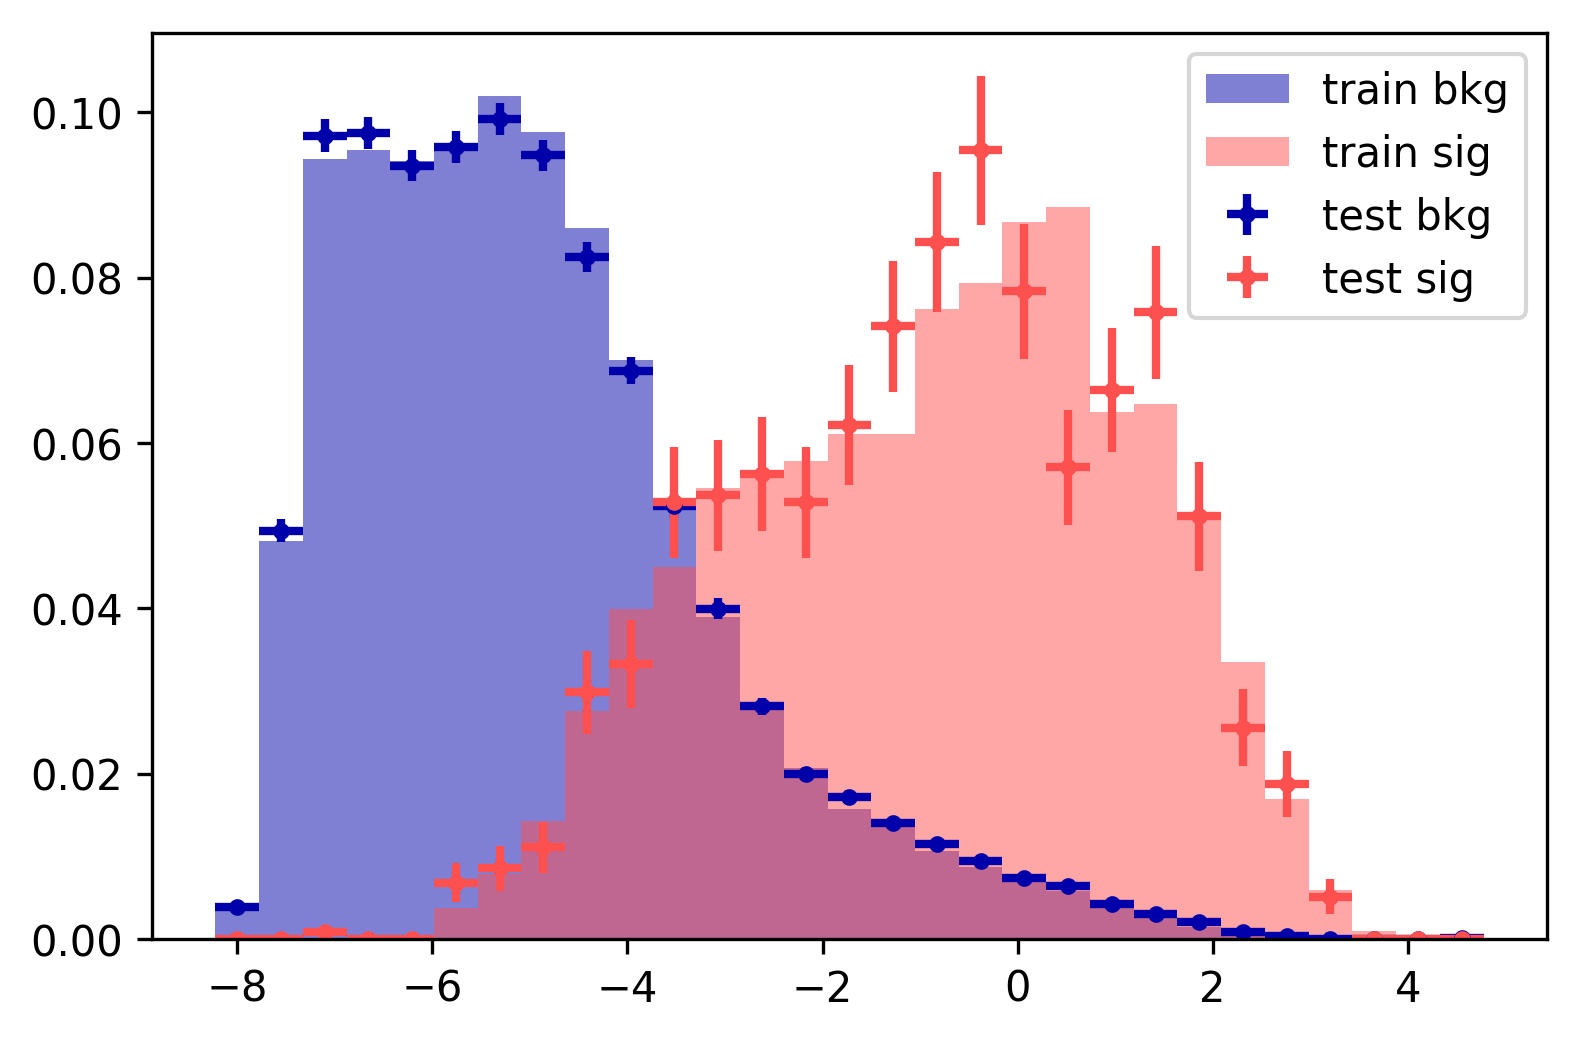

In [194]:
n = True
binw = binning[1] - binning[0]

N_a_bkg = np.histogram(a_bkg,bins=binning)[0]
norm_a_bkg = 1.*len(a_bkg)
N_a_sig = np.histogram(a_sig,bins=binning)[0]
norm_a_sig = 1.*len(a_sig)

#plt.hist(a_bkg,bins=binning,label='train bkg',alpha=0.5)
#plt.hist(a_sig,bins=binning,label='train sig',alpha=0.5)

plt.bar(left=binning[:-1],height=N_a_bkg/norm_a_bkg,width=binw,label='train bkg',alpha=0.5)
plt.bar(left=binning[:-1],height=N_a_sig/norm_a_sig,width=binw,label='train sig',alpha=0.5)



N_bkg = np.histogram(b_bkg,bins=binning)[0]
norm_bkg = 1.*len(b_bkg)

N_sig = np.histogram(b_sig,bins=binning)[0]
norm_sig = 1.*len(b_sig)

#print(sum(N_sig/norm_sig))

plt.errorbar(binning[:-1],N_bkg/norm_bkg,xerr=binw/2.,label='test bkg',
            yerr=np.sqrt(N_bkg)/norm_bkg,fmt='.')
plt.errorbar(binning[:-1],N_sig/norm_sig,xerr=binw/2.,label='test sig',
            yerr=np.sqrt(N_sig)/norm_sig,fmt='.')
            

plt.legend()
plt.show()

In [207]:
print N_sig
print N_bkg
print np.sqrt(N_bkg)

sum_sig_cuts = []
sum_bkg_cuts = []

count = 0
for s in N_sig :
    count += s
    sum_sig_cuts.append(count)

count = 0
for s in N_bkg :
    count += s
    sum_bkg_cuts.append(count)

    
print sum_sig_cuts
print sum_bkg_cuts


print np.sqrt(-2*(N_sig+N_bkg)*np.log(1+N_sig/N_bkg) + 2*N_sig)

[  0   0   1   0   0   8  10  13  35  39  62  63  66  62  73  87  99 112
  92  67  78  89  60  30  22   6   0   0   0]
[  99 1271 2503 2510 2409 2467 2555 2441 2125 1770 1349 1029  725  513  443
  362  296  242  189  164  108   78   52   20    8    1    1    1    2]
[  9.95   35.651  50.03   50.1    49.082  49.669  50.547  49.406  46.098
  42.071  36.729  32.078  26.926  22.65   21.048  19.026  17.205  15.556
  13.748  12.806  10.392   8.832   7.211   4.472   2.828   1.      1.      1.
   1.414]
[0, 0, 1, 1, 1, 9, 19, 32, 67, 106, 168, 231, 297, 359, 432, 519, 618, 730, 822, 889, 967, 1056, 1116, 1146, 1168, 1174, 1174, 1174, 1174]
[99, 1370, 3873, 6383, 8792, 11259, 13814, 16255, 18380, 20150, 21499, 22528, 23253, 23766, 24209, 24571, 24867, 25109, 25298, 25462, 25570, 25648, 25700, 25720, 25728, 25729, 25730, 25731, 25733]
[  0.      0.      1.414   0.      0.      4.      4.472   5.099   8.367
   8.832  11.136  11.225  11.489  11.136  12.083  13.191  14.071  14.967
  13.565  11.576 

/home/janik/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in sqrt


1.41379310345


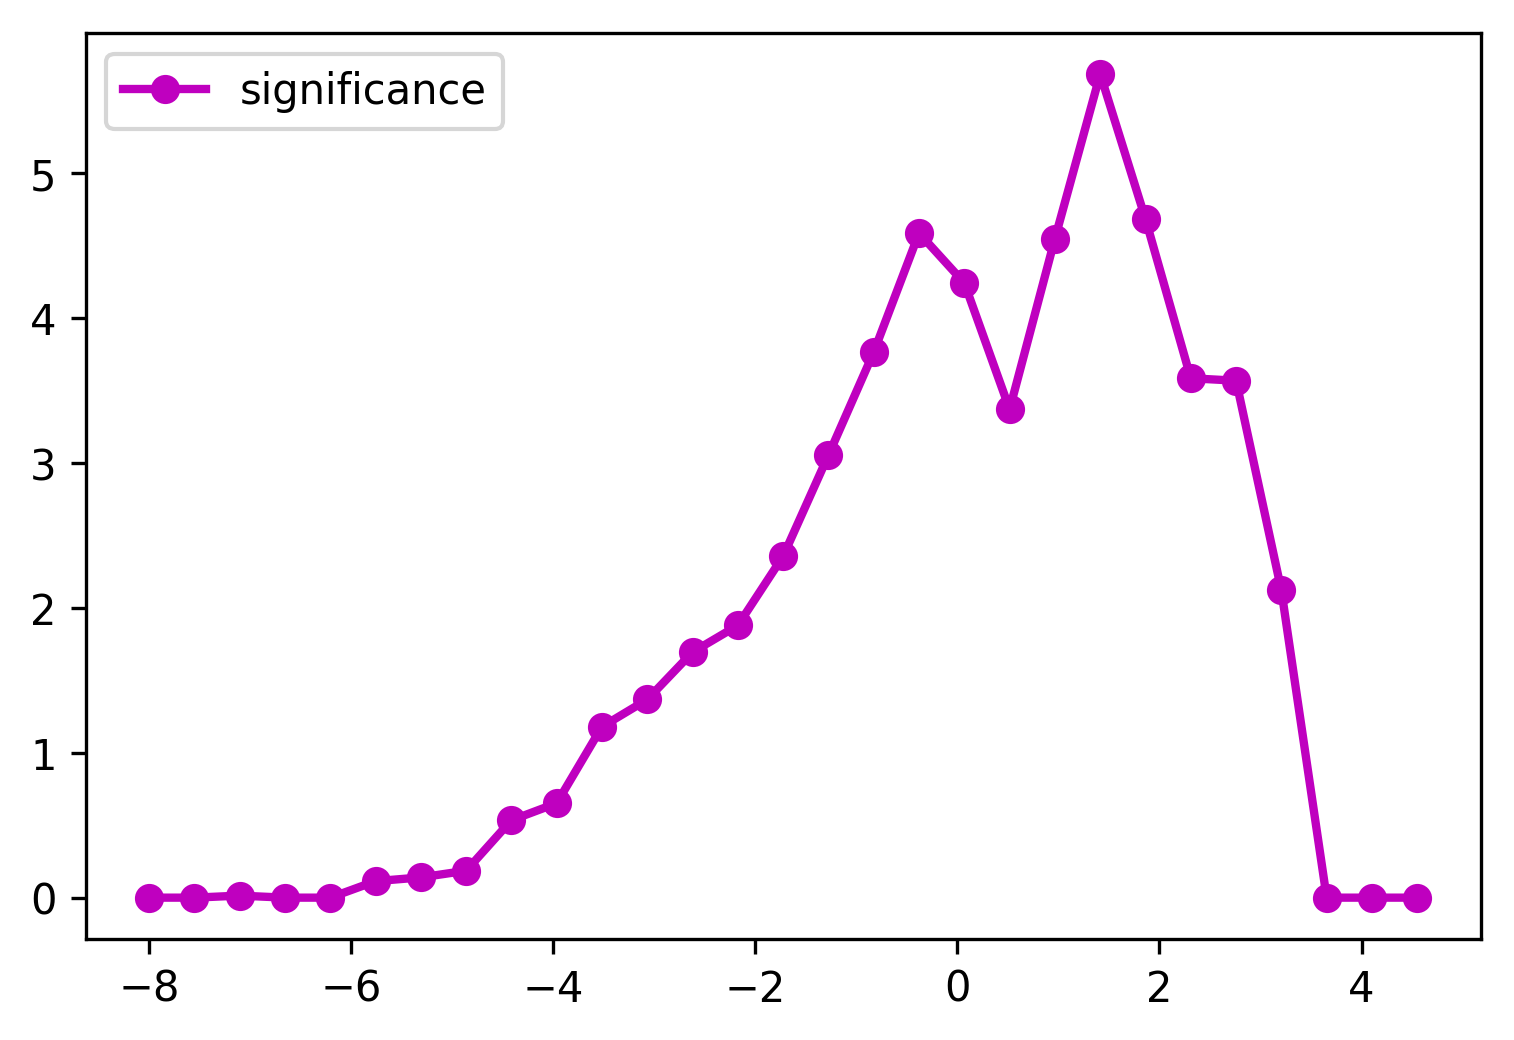

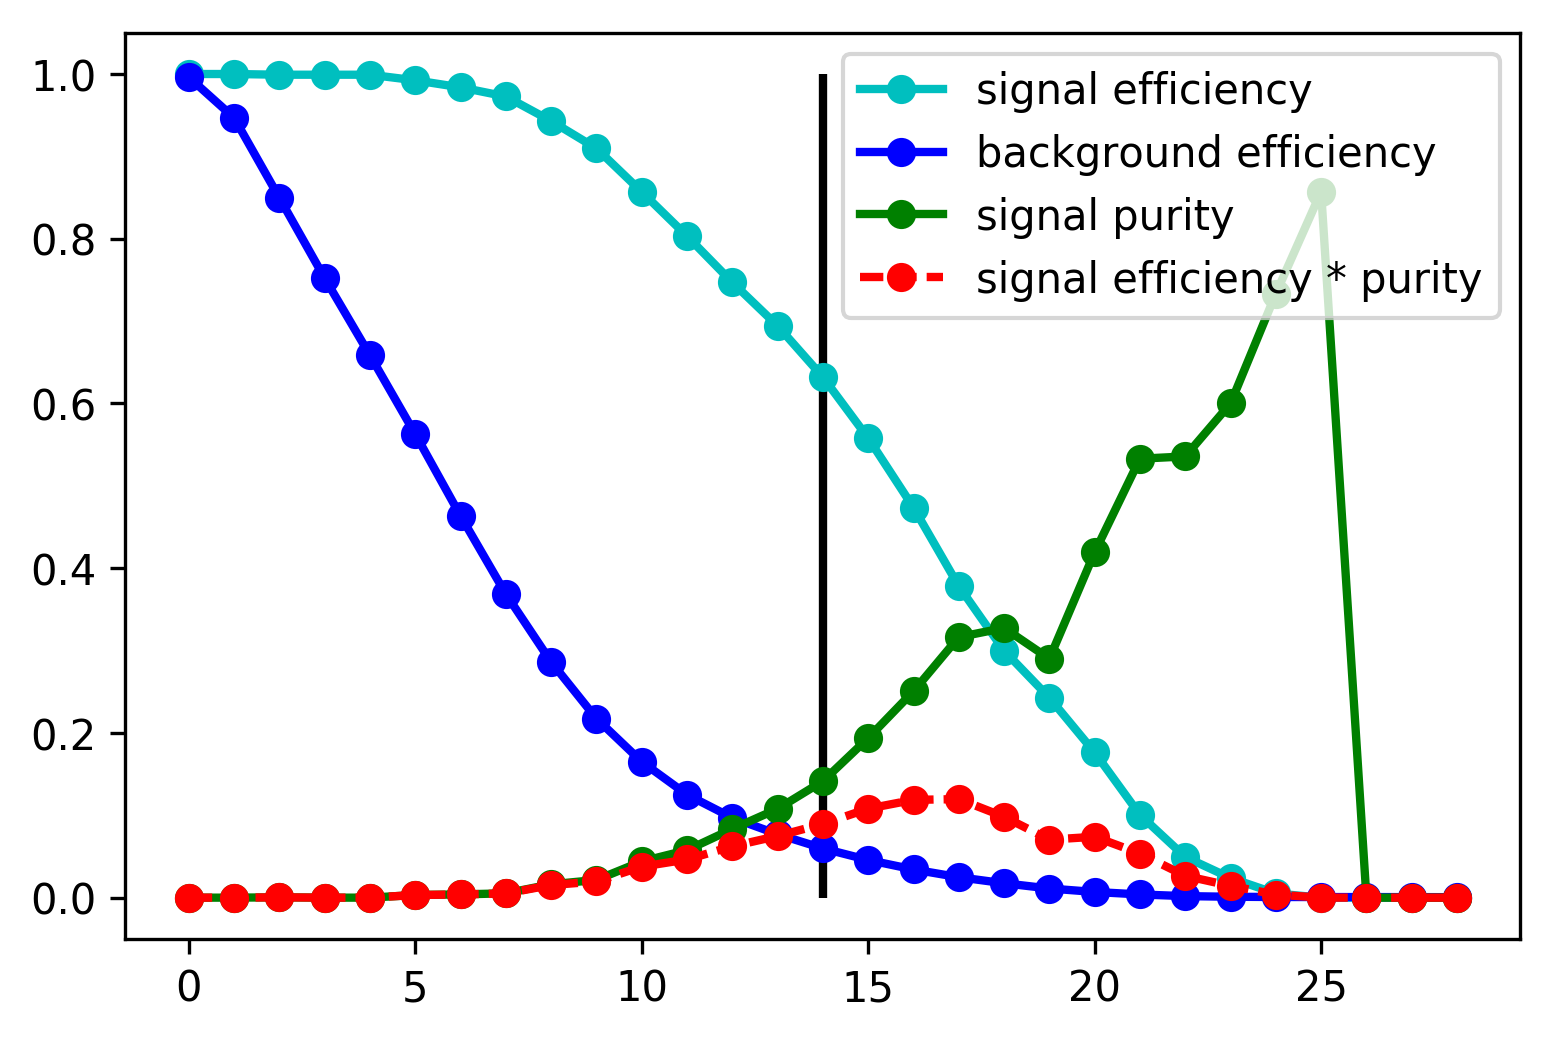

In [212]:
plt.plot(binning[:-1],1.*N_sig/(np.sqrt(N_sig + N_bkg + N_bkg)),'mo-',label='significance')
print binning[:-1][np.argmax(1.*N_sig/(np.sqrt(N_sig + N_bkg + N_bkg)))]
#plt.plot(np.sqrt(-2*(N_sig+N_bkg)*np.log(1+N_sig/N_bkg) + 2*N_sig),'ro--', label='lr significance')
#plt.hlines(3.,0,30)
#plt.vlines(14,0,7)
plt.legend()
plt.show()

plt.vlines(14,0,1)
plt.plot(1.-(np.array(sum_sig_cuts))/norm_sig,'co-',label='signal efficiency')
plt.plot(1.-(np.array(sum_bkg_cuts))/norm_bkg,'bo-',label='background efficiency')
plt.plot(1.*N_sig / (N_sig+N_bkg),'go-',label='signal purity')
plt.plot((1.*N_sig / (N_sig+N_bkg))*(1.-(np.array(sum_sig_cuts))/norm_sig),'ro--',label='signal efficiency * purity')
plt.legend()
plt.show()

In [213]:
cut = 1.41379310345

In [214]:
import cPickle
# save the classifier
with open('my_dumped_classifier.pkl', 'wb') as fid:
    cPickle.dump(grbcl, fid)    

# load it again
#with open('my_dumped_classifier.pkl', 'rb') as fid:
#    gnb_loaded = cPickle.load(fid)

# New stuff

In [7]:
#clean up unphysical or unkown input features
del df_mH80['irun']
del df_mH80['ievt']
del df_mH80['encm']
del df_mH80['ifi'] #no info
del df_mH80['idp1'] #no info
del df_mH80['idp2'] #no info
del df_mH80['ghmass']

del df_mH80['mvisf']




In [8]:
S_all = len(framesMC_HiggsModels[0])
print S_all

3353


In [9]:
#plt.hist(df_MC_noHiggs['idp1'],bins=100)
#plt.hist(framesMC_HiggsModels[0]['idp2'],bins=100)
#plt.show()

In [10]:
def PrintSelectionEff (frame, S_tot) :
    S_cut = len(frame[frame['class']==1])
    B_cut = len(frame[frame['class']==0])
    
    eff = 1.* S_cut / S_tot
    purity = 1.* S_cut / (S_cut + B_cut) 
    signal_strength = 1.*S_cut / B_cut
    
    print ('efficiency: ', eff)
    print ('purity: ', purity)
    print ('signal strength: ', signal_strength)

In [11]:
def SelectionCut (dataframe, mH_hypo = 85) :
    
    #dataframe = dataframe[dataframe['btag1']>0.15]
    bvalue = 0.18
    
    
    dataframe = dataframe[(dataframe['btag1']>bvalue) | (dataframe['btag2']>bvalue)]
    dataframe = dataframe[(dataframe['mmis']>65)]
    dataframe = dataframe[(dataframe['mvis']<mH_hypo+5)]
    dataframe = dataframe[(dataframe['fmvis']<mH_hypo+5)]
    dataframe = dataframe[(dataframe['mvissc']<mH_hypo+5)]
    
    dataframe = dataframe[(dataframe['ucsdbt0']>1.4)]
    
    
    #dataframe = dataframe[dataframe['btag2']>0.15]
    #dataframe = dataframe[dataframe['acthm']<0.85]
    #dataframe = dataframe[dataframe['mmis']>80]
    
    
    return dataframe

In [12]:
#df_MC_noHiggs = pd.concat(framesMC_NoHiggs)
#df_mH80 = pd.concat([df_MC_noHiggs,framesMC_HiggsModels[0]])

df_mH80 = SelectionCut(dataframe=df_mH80)
PrintSelectionEff(frame=df_mH80,S_tot=S_all)

('efficiency: ', 0.520131225767969)
('purity: ', 0.30752953623699525)
('signal strength: ', 0.44410491469315)


In [13]:
col = df_mH80.columns
print col
a = [u'btag1', u'btag2', u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis',
       u'fth1', u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
       u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2']
print a

Index([u'btag1', u'btag2', u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis',
       u'fth1', u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
       u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2',
       u'pho_num', u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene',
       u'ele_the', u'ele_phi', u'muon_num', u'muon_ene', u'muon_the',
       u'muon_phi', u'weight', u'class'],
      dtype='object')
[u'btag1', u'btag2', u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis', u'fth1', u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1', u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2']


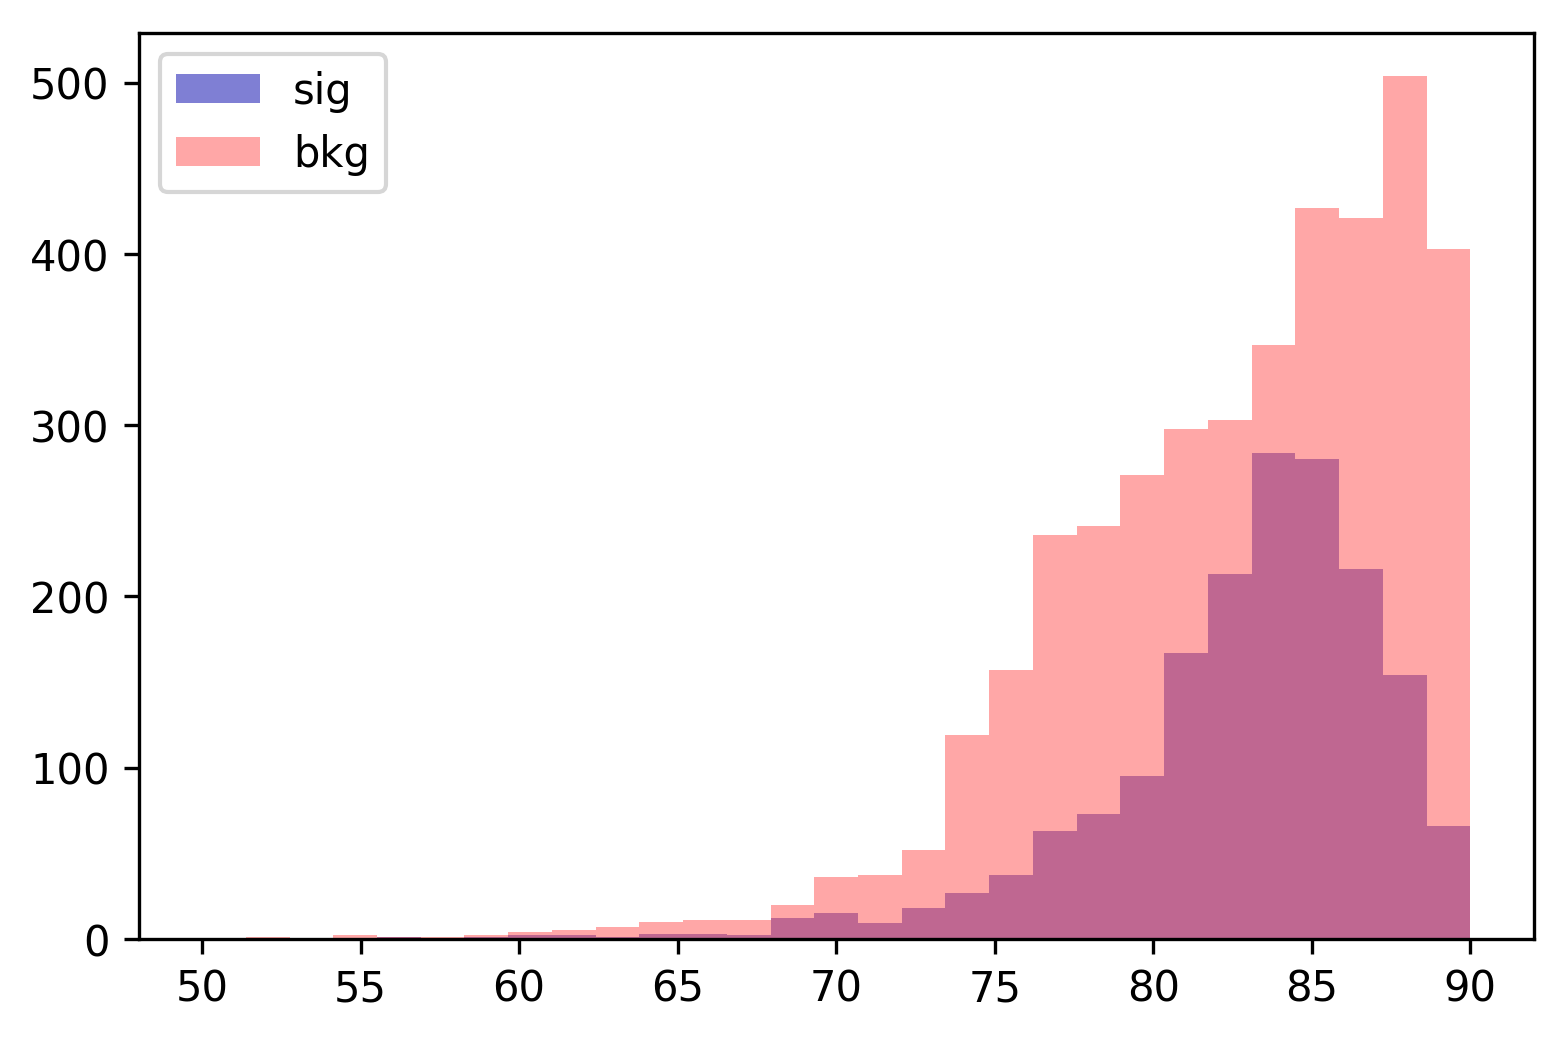

In [14]:
binning = np.linspace(50,90,30)
plt.hist(df_mH80[df_mH80['class']==1]['fmvis'],label='sig',alpha=0.5,bins=binning,normed=False)
plt.hist(df_mH80[df_mH80['class']==0]['fmvis'],label='bkg',alpha=0.5,bins=binning,normed=False)
plt.legend()
plt.show()

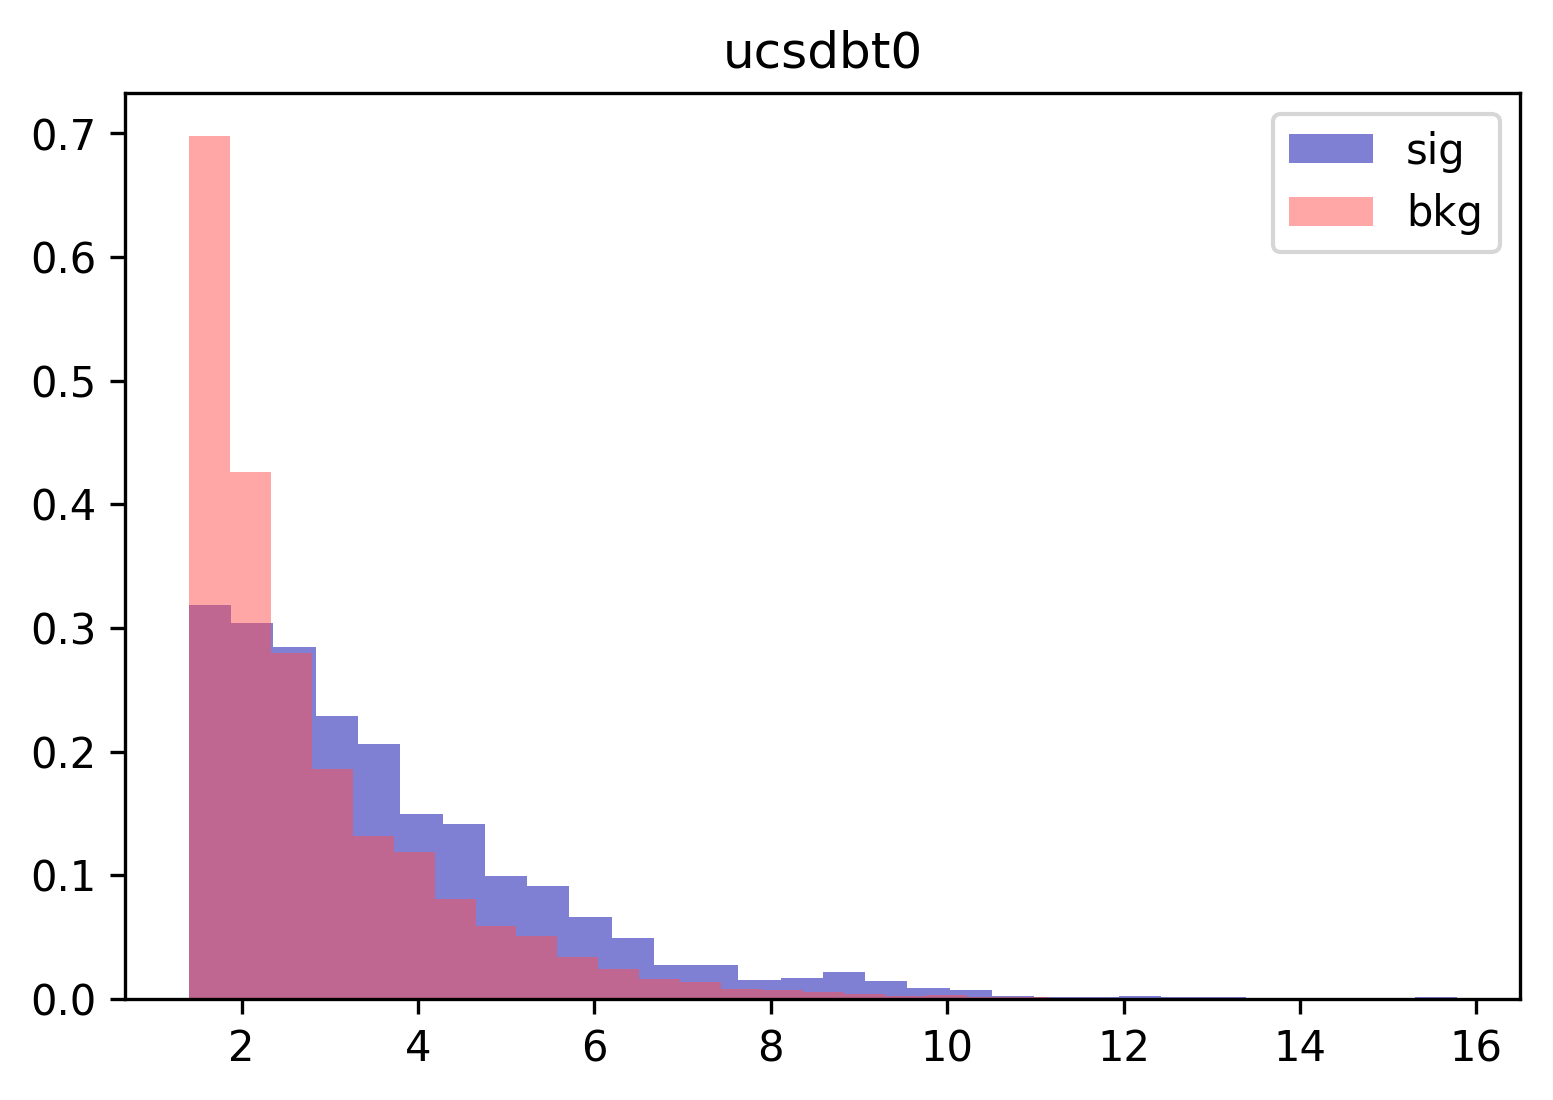

In [15]:
a = ['ucsdbt0']
for var in a:
    plt.title(var)
    plt.hist(df_mH80[df_mH80['class']==1][var],label='sig',alpha=0.5,bins=30,normed=True)
    plt.hist(df_mH80[df_mH80['class']==0][var],label='bkg',alpha=0.5,bins=30,normed=True)
    plt.legend()
    plt.show()

In [16]:
target = df_mH80['class']
del df_mH80['class']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df_mH80, target, stratify=target, random_state=42,
                                                   train_size=0.75)
X_train_w = X_train['weight']
X_test_w = X_test['weight']

print(len(y_train))
print(np.count_nonzero(y_train))

print(1 - 1.*np.count_nonzero(y_train) / len(y_train))

print(len(y_test))
print(np.count_nonzero(y_test))

print(1 - 1.*np.count_nonzero(y_test) / len(y_test))


del X_train['weight']
del X_test['weight']



4253
1308
0.692452386551
1418
436
0.692524682652


In [18]:
logreg = LogisticRegression(C=100).fit(X_train, y_train,sample_weight=X_train_w)
SVM = LinearSVC(C=50).fit(X_train, y_train,sample_weight=X_train_w)


In [19]:
print X_train_w.values

[ 0.001  0.001  0.001 ...,  0.004  0.006  0.001]


In [20]:
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

print("Training set score: {:.3f}".format(SVM.score(X_train, y_train)))
print("Test set score: {:.3f}".format(SVM.score(X_test, y_test)))


Training set score: 0.655
Test set score: 0.659
Training set score: 0.308
Test set score: 0.308


NameError: name 'tree' is not defined

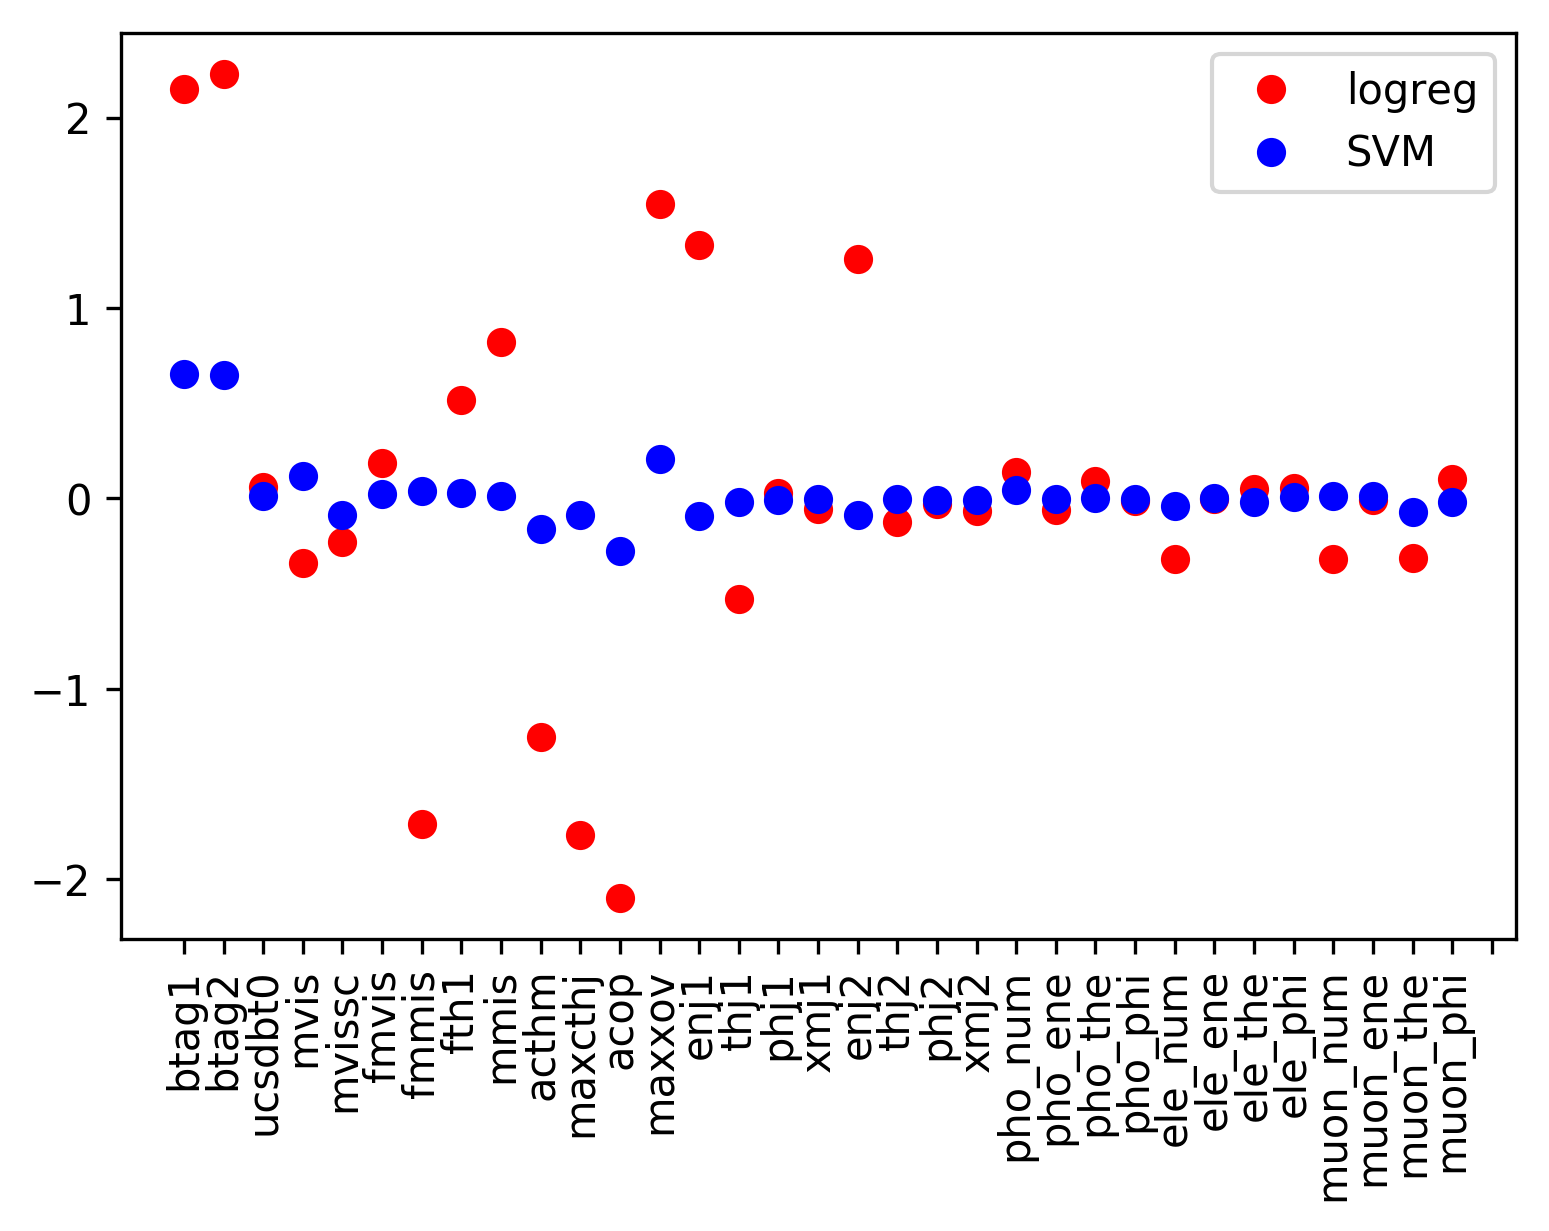

In [22]:
#plt.figure(figsize=(3,3))
plt.plot(logreg.coef_.T,'ro',label='logreg')
plt.plot(SVM.coef_.T,'bo',label='SVM')

#plt.plot(tree.coef_.T,'bo',label='tree')

plt.xticks(range(df_mH80.shape[1]),X_train.columns,rotation=90)
plt.legend()
plt.show()

In [23]:
for l in logreg.coef_ :
    print(l)

[ 2.151  2.227  0.06  -0.341 -0.23   0.188 -1.707  0.518  0.821 -1.254
 -1.766 -2.097  1.548  1.331 -0.528  0.03  -0.056  1.256 -0.124 -0.032
 -0.068  0.139 -0.058  0.092 -0.015 -0.315 -0.002  0.05   0.057 -0.316
 -0.007 -0.314  0.099]


In [24]:
X_train.columns

Index([u'btag1', u'btag2', u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis',
       u'fth1', u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
       u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2',
       u'pho_num', u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene',
       u'ele_the', u'ele_phi', u'muon_num', u'muon_ene', u'muon_the',
       u'muon_phi'],
      dtype='object')

In [37]:
tree = DecisionTreeClassifier(max_depth=2,random_state=0)
tree.fit(X_train,y_train,sample_weight=X_train_w.values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [38]:
from sklearn.tree import export_graphviz
import graphviz

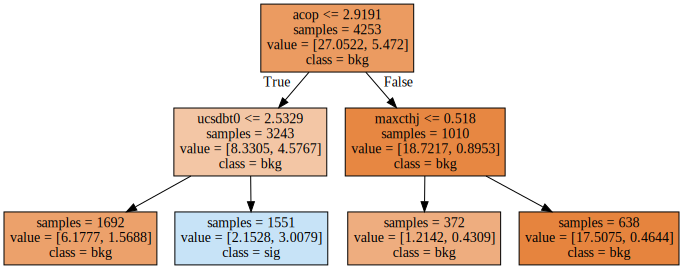

In [39]:
export_graphviz(tree,out_file='tree.dot',class_names=['bkg','sig'],feature_names=X_train.columns,
               impurity=False,filled=True)

with open('tree.dot') as f :
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [ ]:
print np.shape(logreg.coef_[0])

In [ ]:
for i in logreg.coef_[0] :
    print i

### distribution of variable of interest

In [ ]:
def GetHistogram (df, column, binning) :
  
    return np.histogram(a=df[column],
                        bins = binning,
                        weights=df['weight'])[0]

In [ ]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [ ]:

"""variable_dict = {variable: 'mmis', 
                           'acop',
                           'acthm',
                           'fmvis',
                             'mvis'
    
                }
x_name_dict = { x_name: r'missing mass $m_\mathrm{mis}$',  
                        r'$\pi -$ angles btw jets',
                        r'$|\cos(\phi_\mathrm{polar,pmiss})|$',
                        r'visible mass (Z-adjusted) $m_\mathrm{vis}$',
               r'visible mass $m_\mathrm{vis}$'
    
}

x_unit_dict = { x_unit: r'$\mathrm{GeV} / \mathrm{c}^2$',
                        r'$\mathrm{rad}$',
                        r'$1$',
                        r'GeV',
               r'GeV'
    
}
binning_dict = { binning: np.linspace(50.,130.,20),
                          np.linspace(1.5,np.pi,30),
                          np.linspace(0,1.,20),
                          np.linspace(60,100,20),
                np.linspace(70,100,12)
    
}"""

In [ ]:
path = '/home/janik/StatMethods/Project/plots/VariableDists/'
ensure_dir(file_path=path)
variable = 'ucsdbt0'
x_name = r'b tag special'
x_unit = r'1'
binning = np.append(np.linspace(0,8,10),np.array([10,14]))
save_path = path+variable

In [ ]:
bkg = np.zeros(len(binning)-1)
for dataframe in framesMC_NoHiggs :
    bkg += GetHistogram(df=dataframe,column=variable,binning=binning)

sigModels = [] 
for dataframe in framesMC_HiggsModels :
    sigModels.append(GetHistogram(df=dataframe,column=variable,binning=binning))
    

data_hist = GetHistogram(df=data,column=variable,binning=binning)

In [ ]:
pl.BkgSigHistos(background=bkg,signals=sigModels,data=data_hist,variable_binning=binning,
                x_label=[x_name,x_unit],savepath=None)#save_path)

## The Log-likelihood ratio we define to be

$$
    -2 \log (Q(m_H)) = 2 s_{tot} - 2 \sum_{i=1}^{N_{bins}} N_i \log \left( 1 + \frac{s_i(m_H)}{b_i} \right)
$$

In [ ]:
import stats as stat
reload(stat)

In [ ]:
llr_85 = stat.LogLikRatio(background=bkg,signal=sigModels[0],N_experiments=10000)
llr_90 = stat.LogLikRatio(background=bkg,signal=sigModels[1],N_experiments=10000)
llr_95 = stat.LogLikRatio(background=bkg,signal=sigModels[2],N_experiments=10000)

llr_obs = stat.LogLikRatioObserved(background=bkg,signals=sigModels,data=data_hist)

In [ ]:
path = '/home/janik/StatMethods/Project/plots/loglikeliratio/'
ensure_dir(file_path=path)
save_path = path+variable

In [ ]:
reload(pl)
pl.LogLikRatioPlots([llr_85,llr_90,llr_95],Nbins=100,obs=llr_obs,savepath=None)#save_path)


stuff to try

## Go 2D :-)


In [ ]:
def GetHistogram2D (df, columns, binnings) :
  
    return np.histogram2d(x=df[columns[0]],
                          y=df[columns[1]],
                        bins = [binnings[0],binnings[1]],
                        weights=df['weight']
                         )[0]

In [ ]:
path = '/home/janik/StatMethods/Project/plots/VariableDists_2D/'
ensure_dir(file_path=path)
var1 = 'mvissc'
x_name1 = r'visible mass rescaled'
x_unit1 = r'GeV'
binning1 = np.linspace(0,140,10)

var2 = 'btag1'
x_name2 = r' b tag jet 1'
x_unit2 = r'1'
binning2 = np.linspace(0,1,10)


save_path = path+var1+var2

In [ ]:
bkg = np.zeros((len(binning1)-1,len(binning2)-1))
for dataframe in framesMC_NoHiggs :
    bkg += GetHistogram2D(df=dataframe,columns=[var1,var2],
                          binnings=[binning1,binning2])

   
sigModels = [] 
for dataframe in framesMC_HiggsModels :
    sigModels.append(GetHistogram2D(df=dataframe,
                                    columns=[var1,var2],
                                    binnings=[binning1,binning2]))
    

data_hist = GetHistogram2D(df=data,columns=[var1,var2],
                           binnings=[binning1,binning2])

In [ ]:
plt.imshow(bkg)
plt.show()

for i in xrange(3) :
    plt.imshow(sigModels[i])
    plt.show()

plt.imshow(data_hist)
plt.show()
    

In [ ]:
b = bkg
s = sigModels[0]
s_tot = s.sum()

llr_b_like = []
llr_sPlusb_like = []
N_exp = 10000

for k in xrange(N_exp) :
    N = np.random.poisson(lam=b)
    llr_b_like.append(2*s_tot - 2*np.dot(N,np.log(1+s/b)))

for k in xrange(N_exp) :
    N = np.random.poisson(lam=(s+b))
    llr_sPlusb_like.append(2*s_tot - 2*np.dot(N,np.log(1+s/b)))
    
    


In [ ]:
plt.hist(llr_b_like,40,color='blue',alpha=0.5,label='bkg-like',normed=True)
plt.hist(llr_sPlusb_like,40,color='red',alpha=0.5,label='sig+bkg-like',normed=True)
plt.xlabel(r'$-2 \log (Q)$')
plt.ylabel('p.d.f.')
plt.legend()
plt.show()


In [ ]:
q = np.random.poisson(lam=[10,100])
print(q)

In [ ]:
def LogLikRatio (background, signal, N_experiments=10000) :
    
           
    b = background
    s = signal
    s_tot = s.sum()
    
    llr_b_like = []
    llr_sPlusb_like = []

    for k in xrange(N_experiments) :
        N_b = np.random.poisson(lam=b)
        N_sPlusb = np.random.poisson(lam=(s+b))

        llr_b_like.append(2*s_tot - 2*np.dot(N_b,np.log(1+s/b)))
        llr_sPlusb_like.append(2*s_tot - 2*np.dot(N_sPlusb,np.log(1+s/b)))
    
    return llr_b_like, llr_sPlusb_like
        


In [ ]:
bkg = GetHistogram(qq,column=variable,binning=binning)

In [ ]:
print(len(binning))
print(len(bkg))

print(binning)
print(bkg)
binw = binning[1]-binning[0]
plt.bar(binning[:-1]+binw/2.,bkg,width=binw)
plt.show()

In [ ]:
a = qq.groupby(variable)['weight'].sum()

plt.hist(a)
plt.show()

In [ ]:
for col in qq.columns :
    print(col)

In [ ]:
for col in data :
    print(col)